In [1]:
import matplotlib.pyplot as plt
import neuropacks as packs
import numpy as np
import os

from pratplot.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

%matplotlib inline

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

In [3]:
# base_path = '/Volumes/pss/data'
base_path = '/storage/data'

In [4]:
ccycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# RET 2

In [5]:
ret2_path = os.path.join(base_path, 'ret2/200114_fov1_data.mat')
ret2 = packs.RET2(data_path=ret2_path)

In [6]:
X = ret2.get_response_matrix(cells='tuned', response='max')
stimuli = ret2.angles
unique_stimuli = ret2.unique_angles

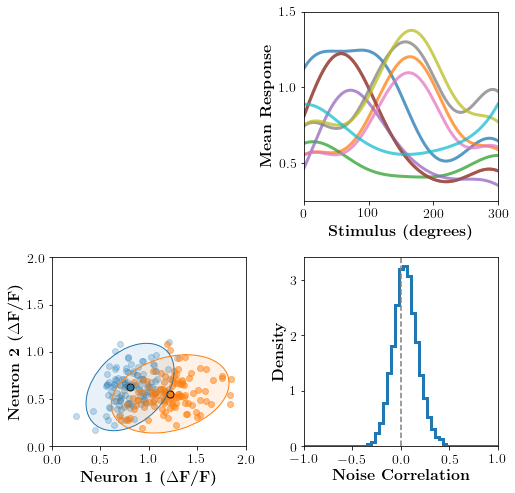

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axes[0, 0].axis('off')

tcax = axes[0, 1]
# Tuning curves
points = np.linspace(0, 300, 1000)
rng = np.random.default_rng(2039191)
examples = rng.integers(low=0, high=X.shape[1], size=len(ccycle))
length_scales = 47.5 * np.ones(len(ccycle))
length_scales[2] = 35
for idx, example in enumerate(examples):
    gpr = GaussianProcessRegressor(RBF(length_scale=length_scales[idx]))
    gpr.fit(stimuli[..., np.newaxis], X[:, example])
    tcax.plot(
        points,
        gpr.predict(points[..., np.newaxis]),
        color=ccycle[idx],
        linewidth=3,
        alpha=0.75
    )

tcax.set_xlim([0, 300])
tcax.set_ylim([.25, 1.5])       
tcax.set_xticks([0, 100, 200, 300])
tcax.set_yticks([0.5, 1.0, 1.5])
tcax.set_xlabel(r'\textbf{Stimulus (degrees)}', fontsize=16)
tcax.set_ylabel(r'\textbf{Mean Response}', fontsize=16)

# Plot example responses
resax = axes[1, 0]

stim1 = 0
stim2 = 60
neuron1 = 32
neuron2 = 25
X1 = X[stimuli == stim1][:, [neuron1, neuron2]]
mu1 = np.mean(X1, axis=0)
X2 = X[stimuli == stim2][:, [neuron1, neuron2]]
mu2 = np.mean(X2, axis=0)

resax.scatter(X1[:, 0],
              X1[:, 1],
              color='C0',
              alpha=0.25)
resax = plot_cov_ellipse(
    np.cov(X1, rowvar=False),
    mu=mu1,
    scale=5.,
    facecolor=[x / 255 for x in list(bytes.fromhex(ccycle[0][1:]))] + [0.1],
    edgecolor=[x / 255 for x in list(bytes.fromhex(ccycle[0][1:]))] + [1.0],
    ax=resax
)
resax = plot_cov_ellipse(
    np.cov(X2, rowvar=False),
    mu=mu2,
    scale=5.,
    facecolor=[x / 255 for x in list(bytes.fromhex(ccycle[1][1:]))] + [0.1],
    edgecolor=[x / 255 for x in list(bytes.fromhex(ccycle[1][1:]))] + [1.0],
    ax=resax
)
resax.scatter(X2[:, 0],
              X2[:, 1],
              color='C1',
              alpha=0.5)
resax.scatter(mu1[0], mu1[1],
              color='C0',
              s=50,
              edgecolor='black')
resax.scatter(mu2[0], mu2[1],
              color='C1',
              s=50,
              edgecolor='black')

resax.set_xlim([0., 2])
resax.set_ylim(resax.get_xlim())
resax.set_xlabel(r'\textbf{Neuron 1 ($\Delta$F/F)}', fontsize=16)
resax.set_ylabel(r'\textbf{Neuron 2 ($\Delta$F/F)}', fontsize=16)

# Plot distribution of noise correlations
ncax = axes[1, 1]
noise_corrs = analysis.all_correlations(X, stimuli)
bins = np.linspace(-1, 1, 50)
ncax.hist(noise_corrs,
          bins=bins,
          density=True,
          color=ccycle[0],
          histtype='step',
          linewidth=3)
ncax.axvline(0, linestyle='--', color='grey')

ncax.set_xlim([-1, 1])
ncax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=16)
ncax.set_ylabel(r'\textbf{Density}', fontsize=16)

# Set axis tick label size
for ax in axes.ravel():
    ax.tick_params(labelsize=14)

plt.savefig('figure2_ret2.pdf', bbox_inches='tight')
plt.show()

# PVC11

In [8]:
pvc11_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey1_gratings.mat')
pvc11_2_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey2_gratings.mat')
pvc11_3_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey3_gratings.mat')
pvc11 = packs.PVC11(data_path=pvc11_path)
pvc11_2 = packs.PVC11(data_path=pvc11_2_path)
pvc11_3 = packs.PVC11(data_path=pvc11_3_path)

In [9]:
X = pvc11.get_response_matrix(transform=None)
stimuli = pvc11.get_design_matrix(form='angle')
unique_stimuli = pvc11.get_angles()

In [10]:
X_cos2 = pvc11.get_design_matrix(form='cosine2')
ols = LinearRegression(fit_intercept=True).fit(X_cos2, X)

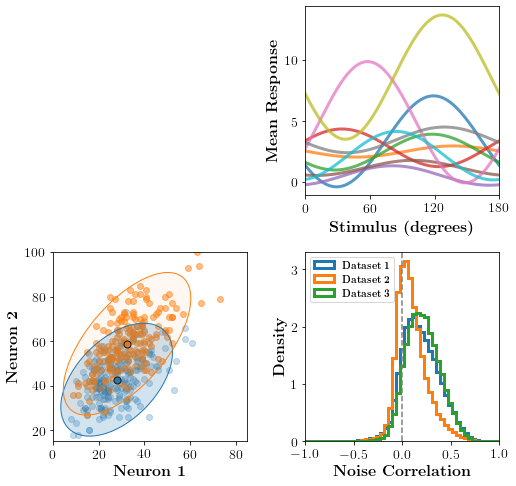

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axes[0, 0].axis('off')

tcax = axes[0, 1]
# Tuning curves
points = np.linspace(0, 300, 1000)
rng = np.random.default_rng(43840912)
examples = rng.integers(low=0, high=X.shape[1], size=len(ccycle))
X_cos2 = pvc11.get_design_matrix(form='cosine2')
ols = LinearRegression(fit_intercept=True).fit(X_cos2, X)

for idx, example in enumerate(examples):
    angles, tc = pvc11.get_tuning_curve(
        form='cosine2',
        tuning_coefs=ols.coef_[example],
        intercept=ols.intercept_[example]
    )

    tcax.plot(
        angles,
        tc,
        color=ccycle[idx],
        linewidth=3,
        alpha=0.75
    )

tcax.set_xlim([0, 180])
#tcax.set_ylim([.25, 1.5])       
tcax.set_xticks([0, 60, 120, 180])
#tcax.set_yticks([0.5, 1.0, 1.5])
tcax.set_xlabel(r'\textbf{Stimulus (degrees)}', fontsize=16)
tcax.set_ylabel(r'\textbf{Mean Response}', fontsize=16)

# Plot example responses
exax = axes[1, 0]

stim1 = 0
stim2 = 30
neuron1 = 57
neuron2 = 34
X1 = X[stimuli == stim1][:, [neuron1, neuron2]]
mu1 = np.mean(X1, axis=0)
X2 = X[stimuli == stim2][:, [neuron1, neuron2]]
mu2 = np.mean(X2, axis=0)

exax.scatter(X1[:, 0],
             X1[:, 1],
             color='C0',
             alpha=0.25)
exax = plot_cov_ellipse(
    np.cov(X1, rowvar=False),
    mu=mu1,
    scale=5.,
    facecolor=[x / 255 for x in list(bytes.fromhex(ccycle[0][1:]))] + [0.2],
    edgecolor=[x / 255 for x in list(bytes.fromhex(ccycle[0][1:]))] + [1.0],
    ax=exax
)
exax = plot_cov_ellipse(
    np.cov(X2, rowvar=False),
    mu=mu2,
    scale=5.,
    facecolor=[x / 255 for x in list(bytes.fromhex(ccycle[1][1:]))] + [0.05],
    edgecolor=[x / 255 for x in list(bytes.fromhex(ccycle[1][1:]))] + [1.0],
    ax=exax
)
exax.scatter(X2[:, 0],
             X2[:, 1],
             color='C1',
             alpha=0.5)
exax.scatter(mu1[0], mu1[1],
             color='C0',
             s=50,
             edgecolor='black')
exax.scatter(mu2[0], mu2[1],
             color='C1',
             s=50,
             edgecolor='black')

exax.set_xlim([0., 85])
exax.set_ylim([15, 100])
exax.set_xticks([0, 20, 40, 60, 80])
exax.set_yticks([20, 40, 60, 80, 100])
exax.set_xlabel(r'\textbf{Neuron 1}', fontsize=16)
exax.set_ylabel(r'\textbf{Neuron 2}', fontsize=16)

# Plot distribution of noise correlations
ncax = axes[1, 1]
X2 = pvc11_2.get_response_matrix(transform=None)
X3 = pvc11_3.get_response_matrix(transform=None)
noise_corrs = analysis.all_correlations(X, stimuli)
noise_corrs2 = analysis.all_correlations(X2, stimuli)
noise_corrs3 = analysis.all_correlations(X3, stimuli)
bins = np.linspace(-1, 1, 50)
ncax.hist(noise_corrs,
          bins=bins,
          density=True,
          color=ccycle[0],
          histtype='step',
          label=r'\textbf{Dataset 1}',
          linewidth=3)
ncax.hist(noise_corrs2,
          bins=bins,
          density=True,
          color=ccycle[1],
          histtype='step',
          label=r'\textbf{Dataset 2}',
          linewidth=3)
ncax.hist(noise_corrs3,
          bins=bins,
          density=True,
          color=ccycle[2],
          histtype='step',
          label=r'\textbf{Dataset 3}',
          linewidth=3)
ncax.axvline(0, linestyle='--', color='grey')
ncax.legend(loc=2)

ncax.set_xlim([-1, 1])
ncax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=16)
ncax.set_ylabel(r'\textbf{Density}', fontsize=16)
ncax.set_yticks([0, 1, 2, 3])

# Set axis tick label size
for ax in axes.ravel():
    ax.tick_params(labelsize=14)
    
plt.savefig('figure2_pvc11.pdf', bbox_inches='tight')
plt.show()